In [4]:
import stan
import pandas as pd
import nest_asyncio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

nest_asyncio.apply()

In [5]:
arx = """

data {
  int<lower=0> T;   // # time points (equally spaced)
  vector[T] y;      // mean corrected return at time t
  vector[T] X;
  vector[T] M;
  
  vector[T] D_sun;
  vector[T] D_sat;
  vector[T] D_mon;
}

parameters {
  real phi_1;
  real phi_2;
  real phi_3;
  real phi_4;
  
  real psi_1;
  real d_1;
  real d_2;
  real d_3;
}
transformed parameters {
  vector[T] y_fit;
  for (t in 4:800) {
    y_fit[t] = y[t] - phi_1*y[t-1] - phi_2*y[t-2] - phi_3*y[t-3] - phi_4*M[t-1] - psi_1 * X[t] - d_1*D_mon[t] - d_2 * D_sat[t] - d_3 * D_sun[t];
  }
}
model {
  for (t in 4:800) {
    y_fit[t] ~ normal(0, 1);
  }
}
generated quantities {  
  vector[T] y_rep = y;
  for (t in 800:T) {
    y_rep[t] = phi_1 * y[t-1] + phi_2*y[t-2] + phi_3*y[t-3] + phi_4*M[t-1] + d_1*D_mon[t] + d_2*D_sat[t] + d_3*D_sun[t] + psi_1 * X[t];
  }
}
"""

In [6]:
def generate_results_raw(zone, hour):
    data = { 1
        }

    posterior = stan.build(arx, data=data)
    fit = posterior.sample(num_chains=4)
    df = fit.to_frame()
    df.to_csv(f'/home/tim/dv/bsv_inference/results/arx_{zone}/arx_{zone}_hour_{hour}.csv', index=False)
    return

In [12]:
arx_2 = """

data {
  int<lower=0> T;   // # time points (equally spaced)
  vector[T] y;      // mean corrected return at time t
  vector[T] X;
  vector[T] M;
  
  vector[T] D_sun;
  vector[T] D_sat;
  vector[T] D_mon;
}

parameters {
  real phi_1;
  real phi_2;
  //real phi_3;
  real phi_4;
  
  real psi_1;
  real d_1;
  real d_2;
  real d_3;
}
transformed parameters {
  vector[T] y_fit;
  for (t in 4:800) {
    y_fit[t] = (y[t]-y[t-1]) - phi_1*(y[t-1]-y[t-2]) - phi_2*(y[t-2]-y[t-3]) - phi_4*M[t-1] - d_1*D_mon[t] - d_2 * D_sat[t] - d_3 * D_sun[t]; //  - psi_1 * X[t];
  }
}
model {
  for (t in 4:800) {
    y_fit[t] ~ normal(0, 1);
  }
}
generated quantities {  
  vector[T] y_rep = y;
  for (t in 800:T) {
    y_rep[t] = y[t-1] + phi_1 * (y[t-1] - y[t-2]) + phi_2*(y[t-2] - y[t-3]) + phi_4*M[t-1] + d_1*D_mon[t] + d_2*D_sat[t] + d_3*D_sun[t];// + psi_1 * X[t];
  }
}
"""

In [13]:
def generate_results_raw_2(zone, hour):
    data = { 
        "T": 1000,
        "y": np.log(pd.read_csv(f'/home/tim/dv/bsv_inference/data_raw/prices_raw/zone_{zone}/zone_{zone}_hour_{hour}.csv')['prices']).to_numpy()[552:],
        "X": np.squeeze(np.log(pd.read_csv(f'/home/tim/dv/bsv_inference/data_raw/temperature_raw/zone_{zone}/zone_{zone}_hour_{hour}.csv', usecols=['temp']).to_numpy()))[552:],
        "M": np.squeeze(np.log(pd.read_csv('/home/tim/dv/bsv_inference/data_raw/temperature/min_zone1.csv', usecols=['temp']).to_numpy()))[552:],

        "D_sun": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/sundays.csv').to_numpy())[552:],
        "D_sat": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/saturdays.csv').to_numpy())[552:],
        "D_mon": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/mondays.csv').to_numpy())[552:]
        }

    posterior = stan.build(arx_2, data=data)
    fit = posterior.sample(num_chains=4)
    df = fit.to_frame()
    df.to_csv(f'/home/tim/dv/bsv_inference/results/arx_2_{zone}/arx_{zone}_hour_{hour}_2.csv', index=False)
    return

In [14]:
for hour in range(24):
    generate_results_raw_2(zone=1, hour=hour)

Building...

/home/tim/.cache/httpstan/4.12.0/models/qcwueyzy/model_qcwueyzy.cpp: In instantiation of ‘stan::scalar_type_t<T2> model_qcwueyzy_namespace::model_qcwueyzy::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = false; VecR = Eigen::Matrix<double, -1, 1>; VecI = Eigen::Matrix<int, -1, 1>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_not_st_var<VecR>* <anonymous> = 0; stan::scalar_type_t<T2> = double; std::ostream = std::basic_ostream<char>]’:
/home/tim/.cache/httpstan/4.12.0/models/qcwueyzy/model_qcwueyzy.cpp:762:47:   required from ‘T_ model_qcwueyzy_namespace::model_qcwueyzy::log_prob(Eigen::Matrix<T_job_param, -1, 1>&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = false; T_ = double; std::ostream = std::basic_ostream<char>]’
/home/tim/anaconda3/envs/thesis_env/lib/python3.9/site-packages/httpstan/include/stan/model/model_base_crtp.


Building: 9.3s, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (600/8000)
Sampling:

Building...



Building: found in cache, done.Messages from stanc:
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:

In [8]:
for hour in range(24):
    generate_results_raw(zone=2, hour=hour)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   

In [36]:
# Define initial date
initial_date = '2023-11-09'
# Define number of days
num_days = 143
log_prices_arr = []
for i in range(600, 743):
    tf = df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['25%']
    sf = df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['75%']
    no_outliers = [n for n in df[f'y_rep.{i}'].to_numpy() if (tf < n < sf)]

    log_prices_arr.append(np.median(no_outliers))

log_prices_arr = np.array(log_prices_arr)

prices = np.exp(log_prices_arr)
# Create datetime range starting from initial date
date_range = pd.date_range(start=initial_date, periods=num_days)
print(date_range.shape)
print(log_prices_arr.shape)
# Create a DataFrame with datetime and corresponding values
res_df = pd.DataFrame({'Datetime': np.array(date_range), 'LogPrices': np.array(log_prices_arr), 'Prices': np.array(prices)})
res_df['LogDiff'] = np.log(res_df['Prices']).diff()

fq = []
tq = []
ff = []
lf = []
for i in range(600, 743):
    fq.append(df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['25%'])
    tq.append(df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['75%'])
    ff.append(df[f'y_rep.{i}'].describe(percentiles=[0.05, 0.25, 0.5, 0.75])['5%'])
    lf.append(df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])['95%'])

res_df['first_quartile'] = fq
res_df['third_quartile'] = tq
res_df['five_pc'] = ff
res_df['nintetyfive_pc'] = lf
print(res_df)

(143,)
(143,)
      Datetime  LogPrices      Prices   LogDiff  first_quartile  \
0   2023-11-09   6.392718  597.478029       NaN        4.294411   
1   2023-11-10   6.340910  567.312066 -0.051808        4.259267   
2   2023-11-11   6.403682  604.065006  0.062772        4.332000   
3   2023-11-12   6.376450  587.837208 -0.027232        4.299899   
4   2023-11-13   6.334713  563.807394 -0.041737        4.265077   
..         ...        ...         ...       ...             ...   
138 2024-03-26   6.657097  778.287961  0.034694        4.592696   
139 2024-03-27   6.604320  738.277604 -0.052777        4.570568   
140 2024-03-28   6.593037  729.994760 -0.011283        4.559452   
141 2024-03-29   6.566147  710.626445 -0.026890        4.556671   
142 2024-03-30   6.685105  800.394894  0.118958        4.596960   

     third_quartile   five_pc  nintetyfive_pc  
0          8.540133  1.194449       11.740007  
1          8.463787  1.188280       11.584594  
2          8.513542  1.274201       1

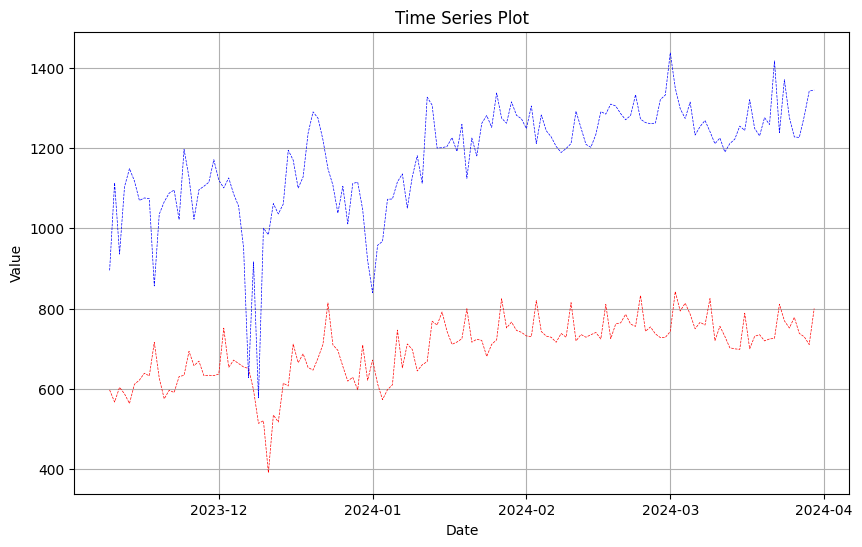

In [37]:
plt.figure(figsize=(10, 6))
# plt.plot(res_df['Datetime'], res_df['Prices'], linestyle='-', color='black', linewidth = 0.5)
fact = pd.read_csv('/home/tim/dv/bsv_inference/data_raw/prices/zone_1_hour_4.csv')[3600:]
# plt.plot(res_df['Datetime'], np.exp(res_df['five_pc']), linestyle=':', color='black', linewidth = 0.5)
# plt.plot(res_df['Datetime'], np.exp(res_df['nintetyfive_pc']), linestyle=':', color='black', linewidth = 0.5)
# plt.plot(res_df['Datetime'], np.exp(res_df['first_quartile']), linestyle='--', color='black', linewidth = 0.5)
# plt.plot(res_df['Datetime'], np.exp(res_df['third_quartile']), linestyle='--', color='black', linewidth = 0.5)
plt.plot(res_df['Datetime'], res_df['Prices'], linestyle='--', color='red', linewidth = 0.5)
plt.plot(res_df['Datetime'], fact['prices'], linestyle='--', color='blue', linewidth = 0.5)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()